In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, lfilter

from scipy.signal import butter, sosfiltfilt, detrend, savgol_filter
#from sklearn.preprocessing import MinMaxScaler

## Частотные фильтры и методы

### 1. Полосовой фильтр Баттерворта

Это электронный/цифровой фильтр, который пропускает сигналы только в заданном диапазоне частот (полосе пропускания) и подавляет все частоты за её пределами.

Удаление шумов:

Низкочастотные помехи (дыхание, дрейф базовой линии).

Высокочастотные шумы (артефакты движений, помехи от датчика).

Выделение полезного сигнала:
Например, пульсовая волна в PPG обычно лежит в диапазоне 0.5–10 Гц

Пропускает частоты между lowcut и highcut (например, 0.5–10 Гц).

Подавляет всё, что ниже lowcut и выше highcut.

Чем выше порядок (например, order=5), тем круче спад амплитуды за пределами полосы.

In [4]:
# из noise_reduction.py
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpassfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
data = pd.read_pickle('/home/artem/Documents/2_course/Project ML/WESAD/S2/S2.pkl')
ppg_signal = data['signal']['wrist']['BVP'].flatten()
labels = data['label'] 

st_with = 2010        # Начальная секунда (4410)
sec = 20              # Длина сегмента (20 секунд)
fs_ppg = 64           # Частота дискретизации PPG (Гц)
fs_label = 700        # Частота дискретизации меток (Гц)

In [14]:
# Для PPG (64 Гц)
start_idx_ppg = st_with * fs_ppg
end_idx_ppg = start_idx_ppg + sec * fs_ppg

# Для меток (700 Гц)
start_idx_label = st_with * fs_label
end_idx_label = start_idx_label + sec * fs_label

# Берем срезы данных
ppg_segment = ppg_signal[start_idx_ppg:end_idx_ppg]
labels_segment = labels[start_idx_label:end_idx_label]

filtered_ppg = butter_bandpassfilter(ppg_segment, 0.01, 20, fs_ppg)

time_ppg = np.arange(0, sec, 1/fs_ppg)[:len(ppg_segment)]
time_labels = np.arange(0, sec, 1/fs_label)[:len(labels_segment)]

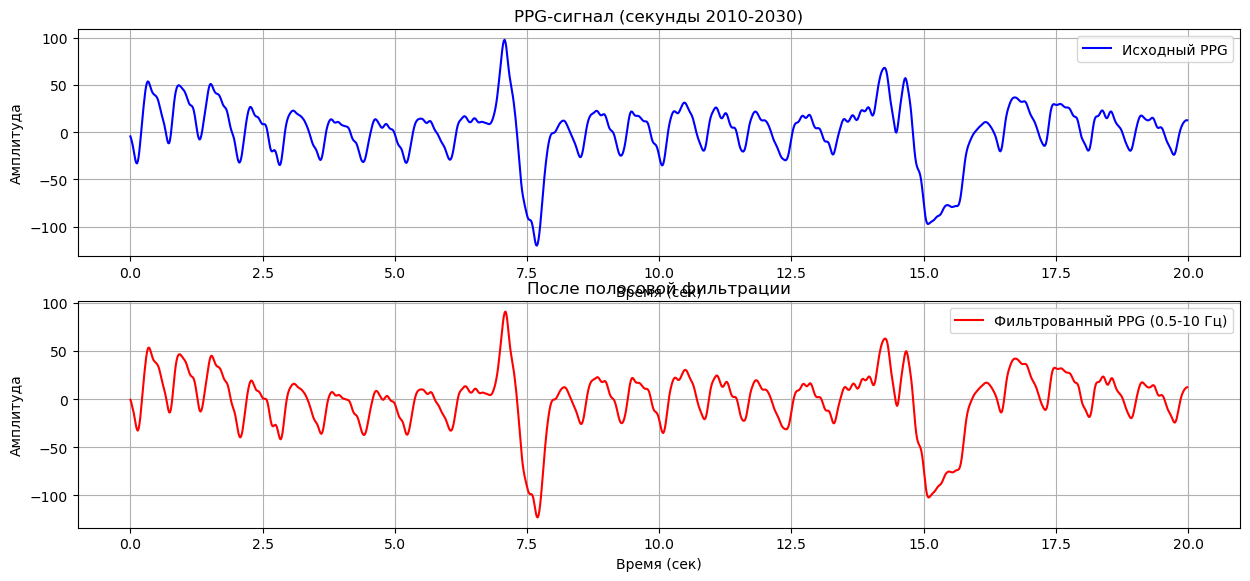

In [15]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(time_ppg, ppg_segment, color='b', label='Исходный PPG')
plt.title(f'PPG-сигнал (секунды {st_with}-{st_with + sec})')
plt.xlabel('Время (сек)')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_ppg, filtered_ppg, color='r', label='Фильтрованный PPG (0.5-10 Гц)')
plt.title('После полосовой фильтрации')
plt.xlabel('Время (сек)')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.legend()

### 2. Скользящее среднее (Moving Average)

Простой метод сглаживания сигнала путем усреднения значений в скользящем окне.

Для чего нужен?

Подавление высокочастотного шума (например, артефактов движений в PPG).

Упрощение формы сигнала для последующего анализа (например, детекции пиков).

Принцип работы:
Каждое значение сигнала заменяется средним арифметическим соседних точек в окне заданной длины.

In [8]:
def movingaverage(data, periods=4):
    data_set = np.asarray(data)
    weights = np.ones(periods) / periods
    result = np.convolve(data_set, weights, mode='valid')
    return result

In [16]:
raw_ppg = ppg_signal[start_idx_ppg:end_idx_ppg]
periods = 10   
smoothed_ppg = movingaverage(raw_ppg, periods)

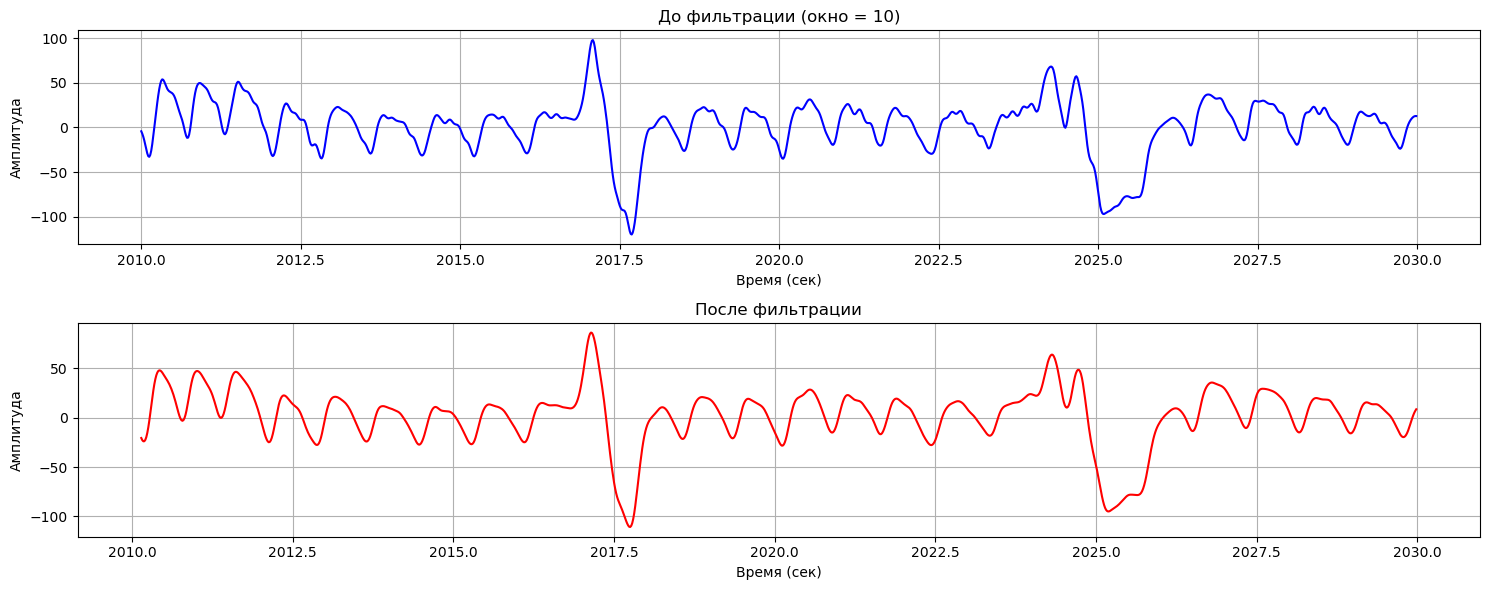

In [17]:
time_raw = np.arange(st_with, st_with + sec, 1/fs_ppg)[:len(raw_ppg)]
time_smoothed = np.arange(st_with + (periods-1)/fs_ppg, st_with + sec, 1/fs_ppg)[:len(smoothed_ppg)]

plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(time_raw, raw_ppg, color='b', label='Исходный PPG')
plt.title(f'До фильтрации (окно = {periods})')
plt.xlabel('Время (сек)')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time_smoothed, smoothed_ppg, color='r', label='Скользящее среднее')
plt.title('После фильтрации')
plt.xlabel('Время (сек)')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.tight_layout()
plt.show()

### 3. Детрендирование (удаление тренда)

Для чего: Удаление низкочастотного тренда (например, дрейфа базовой линии в PPG, вызванного дыханием или движением датчика).

Принцип работы:

Строится линейная регрессия, аппроксимирующая тренд сигнала.

Тренд вычитается из исходного сигнала.

Результат: Сигнал центрируется вокруг нуля, что улучшает анализ пиков и высокочастотных компонент.

In [ ]:
from sklearn.linear_model import LinearRegression

def detrend_signals(signals):
    detrended_signals = []
    X = [k for k in range(0, len(signals))]
    X = np.reshape(X, (len(X), 1))
    model = LinearRegression()
    model.fit(X, signals)
    trend = model.predict(X)
    detrend = [signals[k] - trend[k] for k in range(len(signals))]
    detrended_signals.append(detrend)
    return detrended_signals[0]

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
detrended_ppg = detrend_signals(raw_ppg)

time = np.arange(st_with, st_with + sec, 1/fs_ppg)[:len(raw_ppg)]

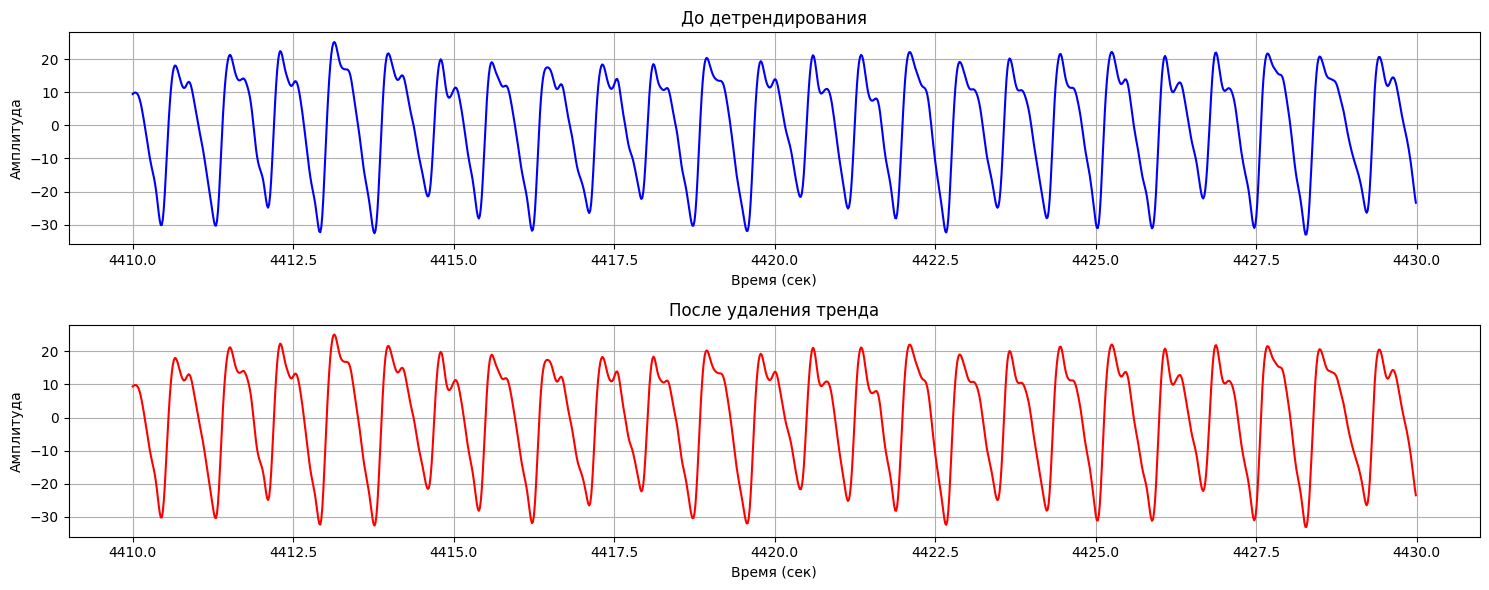

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(time, raw_ppg, color='b', label='Исходный PPG')
plt.title(f'До детрендирования')
plt.xlabel('Время (сек)')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time, detrended_ppg, color='r', label='Детрендированный сигнал')
plt.title('После удаления тренда')
plt.xlabel('Время (сек)')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.tight_layout()
plt.show()

### 4. Нормализация (Min-Max Scaling)



In [ ]:
from sklearn.preprocessing import MinMaxScaler

def ppg_normalization(data, min_range, max_range):
    scaler = MinMaxScaler(feature_range=(min_range, max_range))
    norm_data = scaler.fit_transform(data.reshape(-1, 1))
    return norm_data.flatten()

In [ ]:
normalized_ppg = ppg_normalization(raw_ppg, 0, 1)

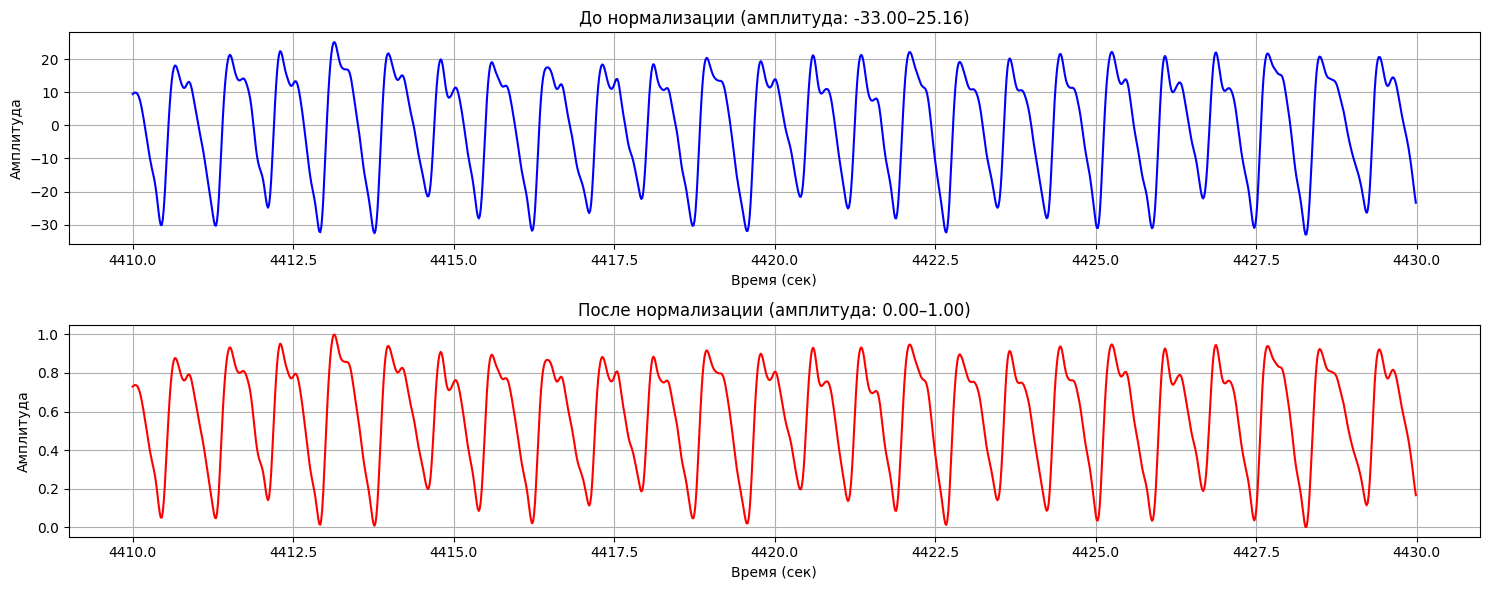

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(time, raw_ppg, color='b', label='Исходный PPG')
plt.title(f'До нормализации (амплитуда: {np.min(raw_ppg):.2f}–{np.max(raw_ppg):.2f})')
plt.xlabel('Время (сек)')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time, normalized_ppg, color='r', label=f'Нормализованный [0, 1]')
plt.title(f'После нормализации (амплитуда: {np.min(normalized_ppg):.2f}–{np.max(normalized_ppg):.2f})')
plt.xlabel('Время (сек)')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.tight_layout()
plt.show()

### 5. Автокорреляция (Auto-Correlation)

Оценка периодичности сигнала (например, частоты сердечных сокращений по PPG).

Обнаружение повторяющихся паттернов.

Принцип работы:

Автокорреляция показывает, насколько сигнал похож на себя со смещением (лагом).

Пики/впадины соответствуют периодическим компонентам.



Не фильтрует сигнал, а анализирует его структуру.

Полезен для оценки доминирующей частоты (например, пульса).

In [ ]:
from scipy import signal


def auto_correlation(filtered_3sec):
    # Вычисление автокорреляции
    lags, acorr, _, _ = plt.acorr(filtered_3sec, normed=True, maxlags=len(filtered_3sec)-1)
    # Поиск впадин (минимумов)
    valley_indexes = signal.argrelextrema(acorr, np.less)[0]
    # Вычисление среднего расстояния между впадинами (для оценки периода)
    diff = np.diff(valley_indexes)
    return np.average(diff) if len(diff) > 0 else 0

Средний период между впадинами: 0.81 сек


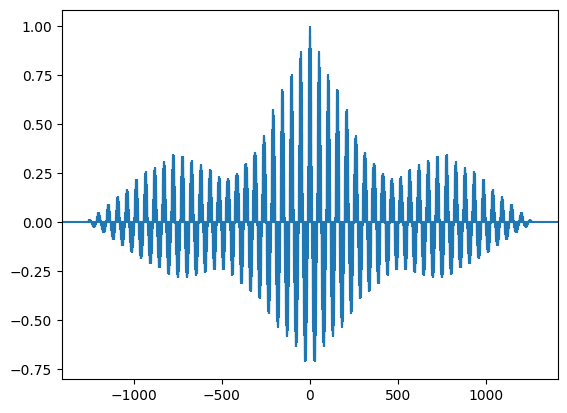

In [ ]:
avg_period = auto_correlation(raw_ppg)
print(f"Средний период между впадинами: {avg_period / fs_ppg:.2f} сек")


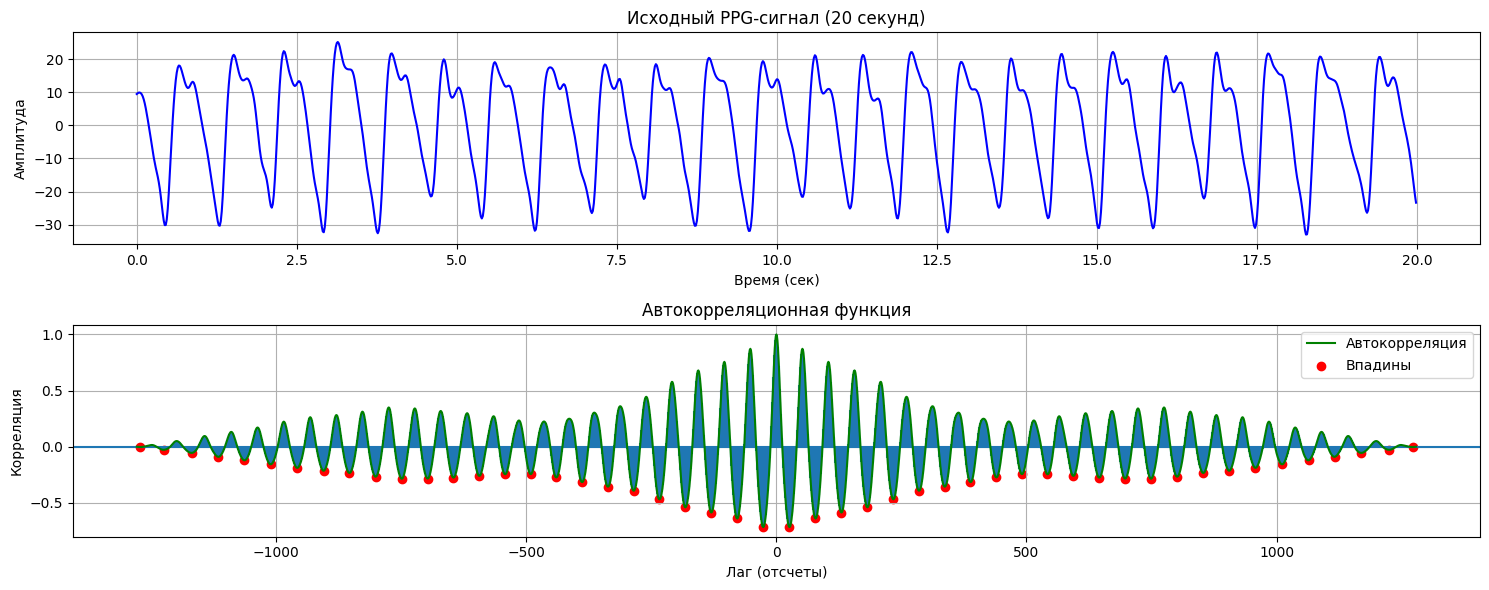

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(np.arange(len(raw_ppg)) / fs_ppg, raw_ppg, color='b', label='Исходный PPG')
plt.title('Исходный PPG-сигнал (20 секунд)')
plt.xlabel('Время (сек)')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.subplot(2, 1, 2)
lags, acorr, _, _ = plt.acorr(raw_ppg, normed=True, maxlags=len(raw_ppg)-1)
valley_indexes = signal.argrelextrema(acorr, np.less)[0]
plt.plot(lags, acorr, color='g', label='Автокорреляция')
plt.scatter(lags[valley_indexes], acorr[valley_indexes], color='r', label='Впадины')
plt.title('Автокорреляционная функция')
plt.xlabel('Лаг (отсчеты)')
plt.ylabel('Корреляция')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### 6. Статистическая фильтрация (eliminate_noise_in_time)

In [ ]:
from scipy import stats

def valley_detection(dataset, fs):
    window = []
    valleylist = []
    listpos = 0
    TH_elapsed = np.ceil(0.36 * fs)
    nvalleys = 0
    valleyarray = []
    
    localaverage = np.average(dataset)
    for datapoint in dataset:
        if (datapoint > localaverage) and (len(window) < 1):
            listpos += 1
        elif (datapoint <= localaverage):
            window.append(datapoint)
            listpos += 1
        else:
            minimum = min(window)
            beatposition = listpos - len(window) + (window.index(minimum))
            valleylist.append(beatposition)
            window = []
            listpos += 1

    for val in valleylist:
        if nvalleys > 0:
            prev_valley = valleylist[nvalleys - 1]
            elapsed = val - prev_valley
            if elapsed > TH_elapsed:
                valleyarray.append(val)
        else:
            valleyarray.append(val)
        nvalleys += 1    
    return valleyarray

def pair_valley(valley):
    return [[valley[i], valley[i+1]] for i in range(len(valley)-1)]

def statistic_detection(signal, fs):
    valley = valley_detection(signal, fs)
    valley = pair_valley(valley)
    stds, kurtosiss, skews = [], [], []
    for v in valley:
        segment = signal[v[0]:v[1]]
        stds.append(np.std(segment))
        kurtosiss.append(stats.kurtosis(segment))
        skews.append(stats.skew(segment))
    return stds, kurtosiss, skews, valley

def statistic_threshold(clean_signal, fs, ths):
    stds, kurtosiss, skews, _ = statistic_detection(clean_signal, fs)
    std_ths = np.mean(stds) + ths[0]
    kurt_ths = np.mean(kurtosiss) + ths[1]
    skews_ths = [np.mean(skews) - ths[2], np.mean(skews) + ths[3]]
    return std_ths, kurt_ths, skews_ths

def eliminate_noise_in_time(data, fs, ths, cycle=15):
    stds, kurtosiss, skews, valley = statistic_detection(data, fs)
    stds_ = [np.mean(stds[i:i+cycle]) for i in range(0, len(stds)-cycle+1, cycle)]
    kurtosiss_ = [np.mean(kurtosiss[i:i+cycle]) for i in range(0, len(kurtosiss)-cycle+1, cycle)]
    skews_ = [np.mean(skews[i:i+cycle]) for i in range(0, len(skews)-cycle+1, cycle)]
    
    clean_indices = []
    for i in range(len(stds_)):
        if (stds_[i] < ths[0]) and (kurtosiss_[i] < ths[1]) and (skews_[i] > ths[2][0]) and (skews_[i] < ths[2][1]):
            start = valley[i*cycle][0]
            end = valley[i*cycle + cycle-1][1]
            clean_indices.extend(range(start, end))
    
    return len(data), len(clean_indices), clean_indices

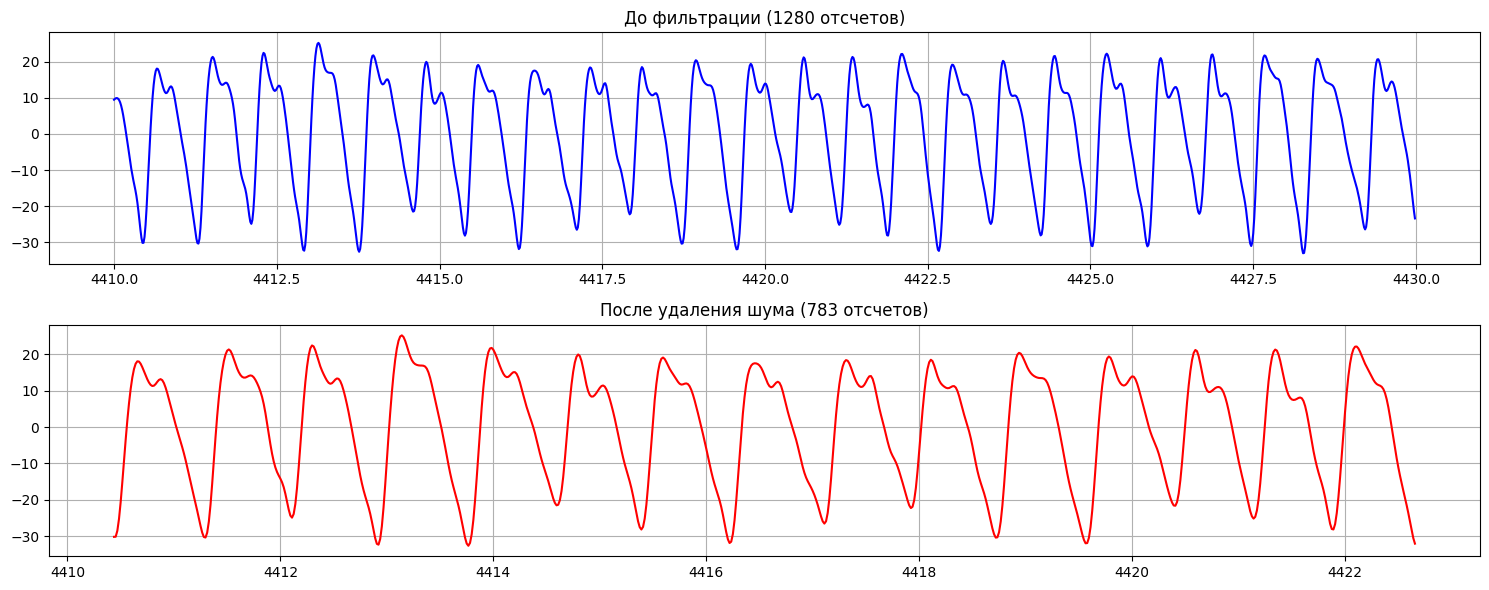

In [ ]:
     
temp_ths = [1.0, 2.0, 1.8, 1.5]  # Пороги для std, kurtosis, skew_low, skew_high
start_idx = st_with * fs_ppg
end_idx = start_idx + sec * fs_ppg
raw_ppg = ppg_signal[start_idx:end_idx]

# Фильтрация
ths = statistic_threshold(raw_ppg[:int(len(raw_ppg)*0.1)], fs_ppg, temp_ths)
len_before, len_after, clean_indices = eliminate_noise_in_time(raw_ppg, fs_ppg, ths, cycle=15)
clean_ppg = raw_ppg[clean_indices]

# Визуализация
time_raw = np.arange(st_with, st_with + sec, 1/fs_ppg)[:len(raw_ppg)]
time_clean = time_raw[clean_indices]

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(time_raw, raw_ppg, color='b', label='Исходный PPG')
plt.title(f'До фильтрации ({len(raw_ppg)} отсчетов)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time_clean, clean_ppg, color='r', label='После фильтрации')
plt.title(f'После удаления шума ({len(clean_ppg)} отсчетов)')
plt.grid(True)

plt.tight_layout()
plt.show()

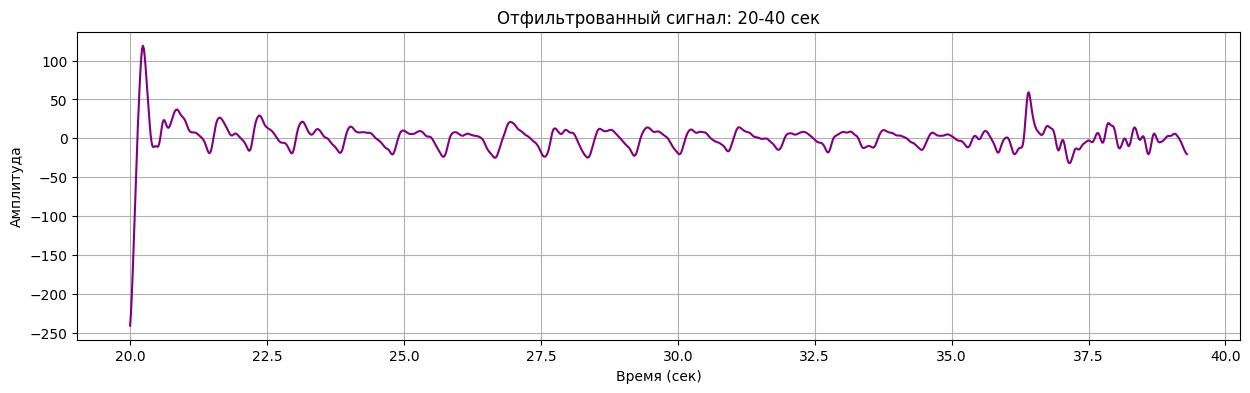

In [ ]:

from scipy import stats

# 1. Загрузка и фильтрация всего сигнала
data = pd.read_pickle('/home/artem/Documents/2_course/Project ML/WESAD/S2/S2.pkl')
full_ppg = data['signal']['wrist']['BVP'].flatten()
fs_ppg = 64
temp_ths = [1.0, 2.0, 1.8, 1.5]

ths = statistic_threshold(full_ppg[:int(len(full_ppg)*0.1)], fs_ppg, temp_ths)
_, _, clean_indices = eliminate_noise_in_time(full_ppg, fs_ppg, ths, cycle=15)
filtered_ppg = full_ppg[clean_indices]

# 2. Временные метки для отфильтрованного сигнала
time_filtered = np.arange(len(full_ppg))[clean_indices] / fs_ppg  # Время в секундах

# 3. Ввод параметров
st_with = int(input("Введите начальную секунду: "))  # Например, 4410
sec = 20

# 4. Поиск данных в заданном интервале
mask = (time_filtered >= st_with) & (time_filtered <= st_with + sec)
filtered_segment = filtered_ppg[mask]
time_segment = time_filtered[mask]

# 5. Визуализация
if len(time_segment) == 0:
    print("Нет данных в этом интервале!")
else:
    plt.figure(figsize=(15, 4))
    plt.plot(time_segment, filtered_segment, color='purple')
    plt.title(f"Отфильтрованный сигнал: {st_with}-{st_with + sec} сек")
    plt.xlabel("Время (сек)")
    plt.ylabel("Амплитуда")
    plt.grid(True)
    plt.show()

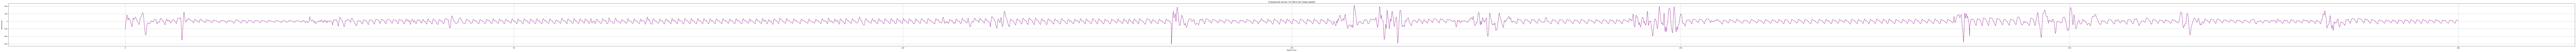

In [ ]:

ths = statistic_threshold(full_ppg[:int(len(full_ppg)*0.1)], fs_ppg, temp_ths)
_, _, clean_indices = eliminate_noise_in_time(full_ppg, fs_ppg, ths, cycle=15)

# 2. Создание непрерывного очищенного сигнала
continuous_ppg = full_ppg[clean_indices]  # Все чистые точки подряд
time_continuous = np.arange(len(continuous_ppg)) / fs_ppg  # Новое время (начинается с 0)


st_with = float(input(f"Введите начальную секунду (0-{time_continuous[-1]:.1f}): "))
sec = 300

# 5. Выбор среза
start_idx = int(st_with * fs_ppg)
end_idx = start_idx + int(sec * fs_ppg)
segment = continuous_ppg[start_idx:end_idx]
time_segment = time_continuous[start_idx:end_idx]

# 6. Визуализация
plt.figure(figsize=(300, 5))
plt.plot(time_segment, segment, color='purple', linewidth=1.5)
plt.title(f"Очищенный сигнал: {st_with}-{st_with+sec} сек (новое время)")
plt.xlabel("Время (сек)")
plt.ylabel("Амплитуда")
plt.grid(True)
plt.savefig(f'./valid_data.png', dpi=300, bbox_inches='tight')

# plt.show()